## Import Libraries 

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

## Assign Path and size 

In [2]:
data_dir = os.getcwd()
train_path = 'Train'
test_path = 'Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3 #rgb
total_classes = 43

## Classes of traffic signs 

In [3]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

## Visualize the dataset 

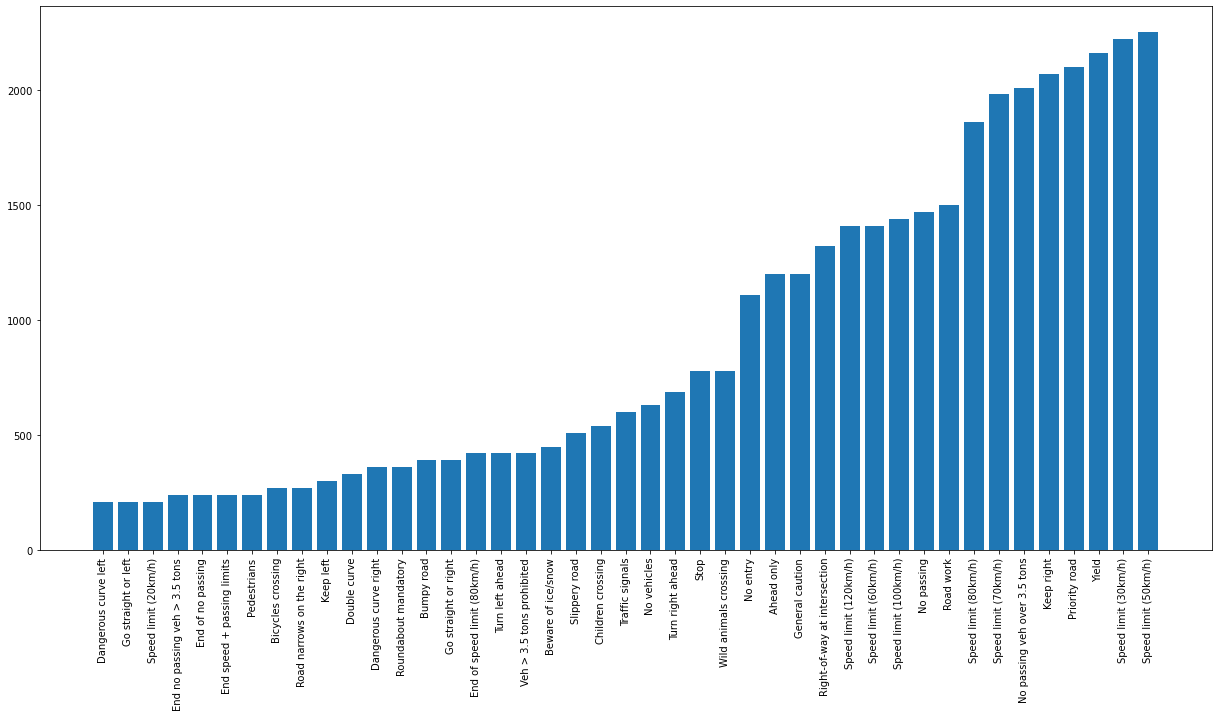

In [4]:
reqFolders = os.listdir(train_path)

train_num = []
class_num = []

for folder in reqFolders:
    train_files = os.listdir(train_path + '/' + folder)
    train_num.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_num, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_num, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_num)
plt.xticks(class_num, rotation='vertical')
plt.show()

## Visualize 20 random test images 

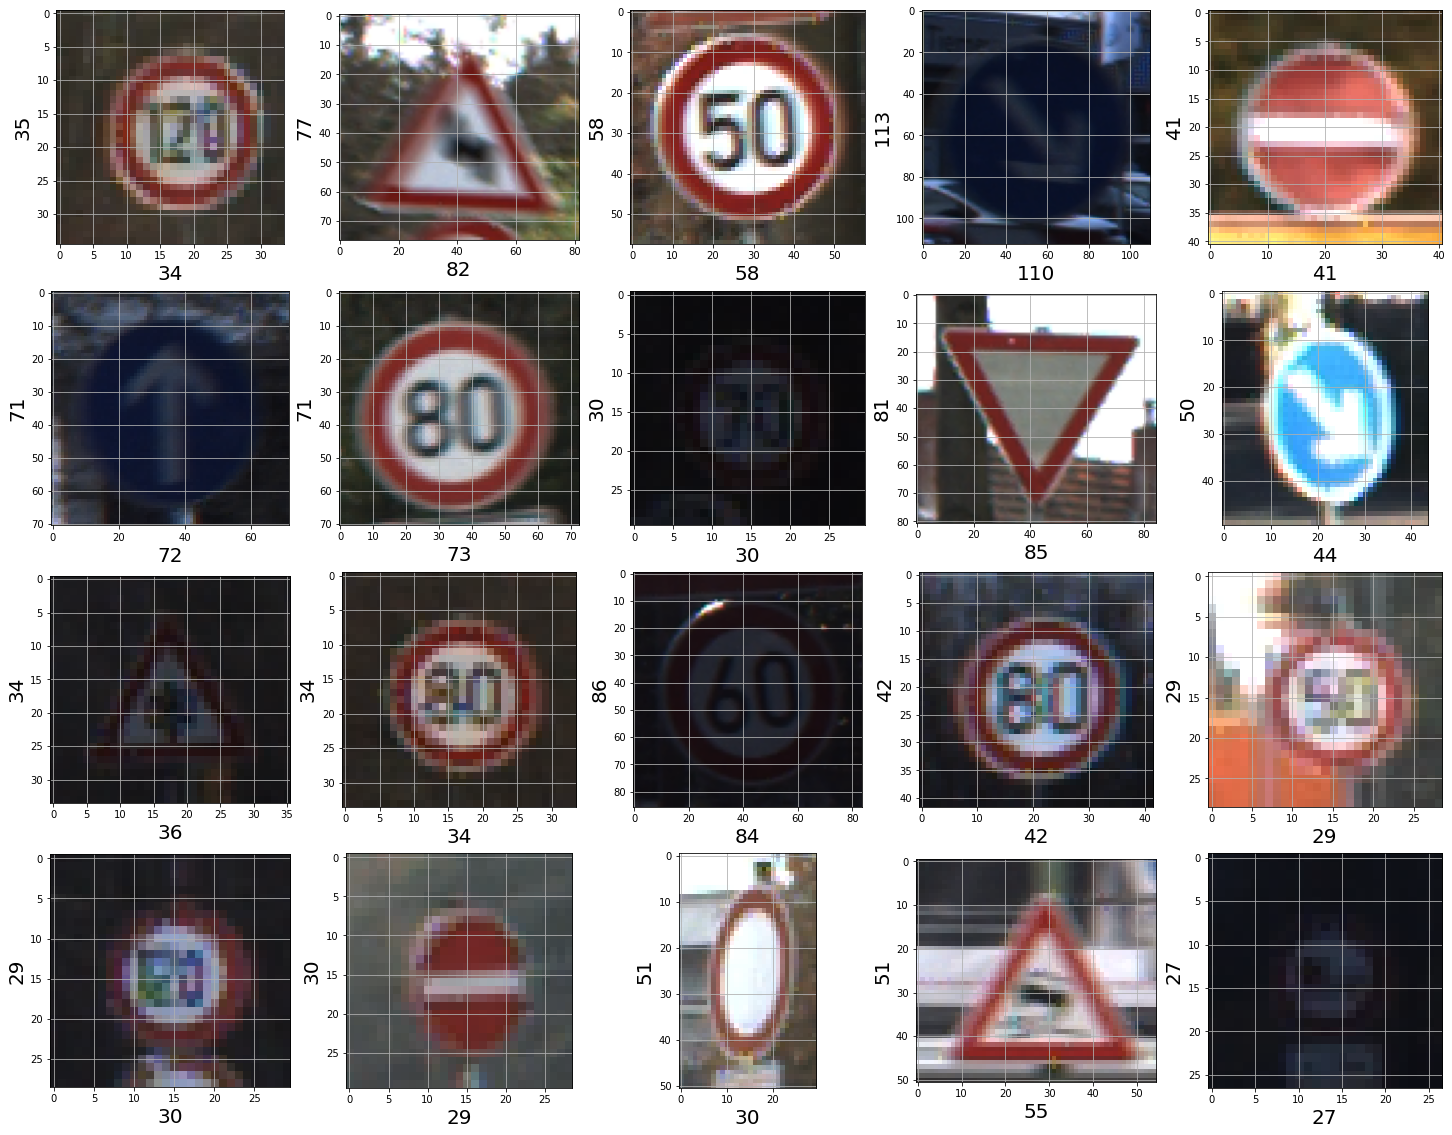

In [5]:
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,21):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

## Preprocess the images 

In [6]:
image_data = []
image_labels = []

for i in range(total_classes):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffle data 

In [7]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting into training and validation set 

In [8]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.2, random_state=0, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train: ", X_train.shape)
print("X_valid: ", X_val.shape)
print("y_train: ", y_train.shape)
print("y_valid: ", y_val.shape)

X_train:  (31367, 30, 30, 3)
X_valid:  (7842, 30, 30, 3)
y_train:  (31367,)
y_valid:  (7842,)


## OneHotEncoding labels 

In [9]:
y_train = keras.utils.to_categorical(y_train, total_classes)
y_val = keras.utils.to_categorical(y_val, total_classes)

print(y_train.shape)
print(y_val.shape)

(31367, 43)
(7842, 43)


## Build Model 

In [10]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])

In [11]:
lr = 0.001
epochs = 30

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmenting data 

In [12]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

## Model Train 

In [13]:
history = model.fit(aug.flow(X_train, y_train, batch_size=64), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/30
491/491 [==============================] - 47s 93ms/step - loss: 1.2372 - accuracy: 0.6710 - val_loss: 1.0748 - val_accuracy: 0.6688
Epoch 2/30
491/491 [==============================] - 48s 99ms/step - loss: 0.2249 - accuracy: 0.9345 - val_loss: 0.0779 - val_accuracy: 0.9765
Epoch 3/30
491/491 [==============================] - 49s 99ms/step - loss: 0.1395 - accuracy: 0.9599 - val_loss: 0.0265 - val_accuracy: 0.9922
Epoch 4/30
491/491 [==============================] - 48s 98ms/step - loss: 0.0821 - accuracy: 0.9763 - val_loss: 0.0208 - val_accuracy: 0.9943
Epoch 5/30
491/491 [==============================] - 50s 102ms/step - loss: 0.0760 - accuracy: 0.9772 - val_loss: 0.0520 - val_accuracy: 0.9827
Epoch 6/30
491/491 [==============================] - 50s 102ms/step - loss: 0.0623 - accuracy: 0.9807 - val_loss: 0.0226 - val_accuracy: 0.9927
Epoch 7/30
491/491 [==============================] - 49s 100ms/step - loss: 0.0515 - accuracy: 0.9851 - val_loss: 0.0118 - val_accura

## Evaluating the model 

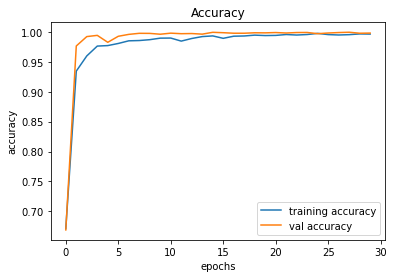

In [14]:
# accuracy 
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

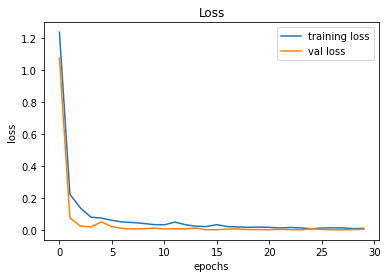

In [15]:
# Loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Testing on test data 

In [16]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255


predict_x=model.predict(X_test) 
pred=np.argmax(predict_x,axis=1)

395/395 [==============================] - 3s 8ms/step


## Accuracy with the test data 

In [17]:
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  98.04433887569279


## Classification report 

In [18]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      0.99       720
           2       0.98      0.99      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      0.99      0.99       660
           5       0.99      0.96      0.98       630
           6       1.00      0.80      0.89       150
           7       0.98      1.00      0.99       450
           8       1.00      1.00      1.00       450
           9       0.99      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.99      0.95      0.97       420
          12       0.99      0.99      0.99       690
          13       0.99      1.00      0.99       720
          14       0.96      1.00      0.98       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on test data 

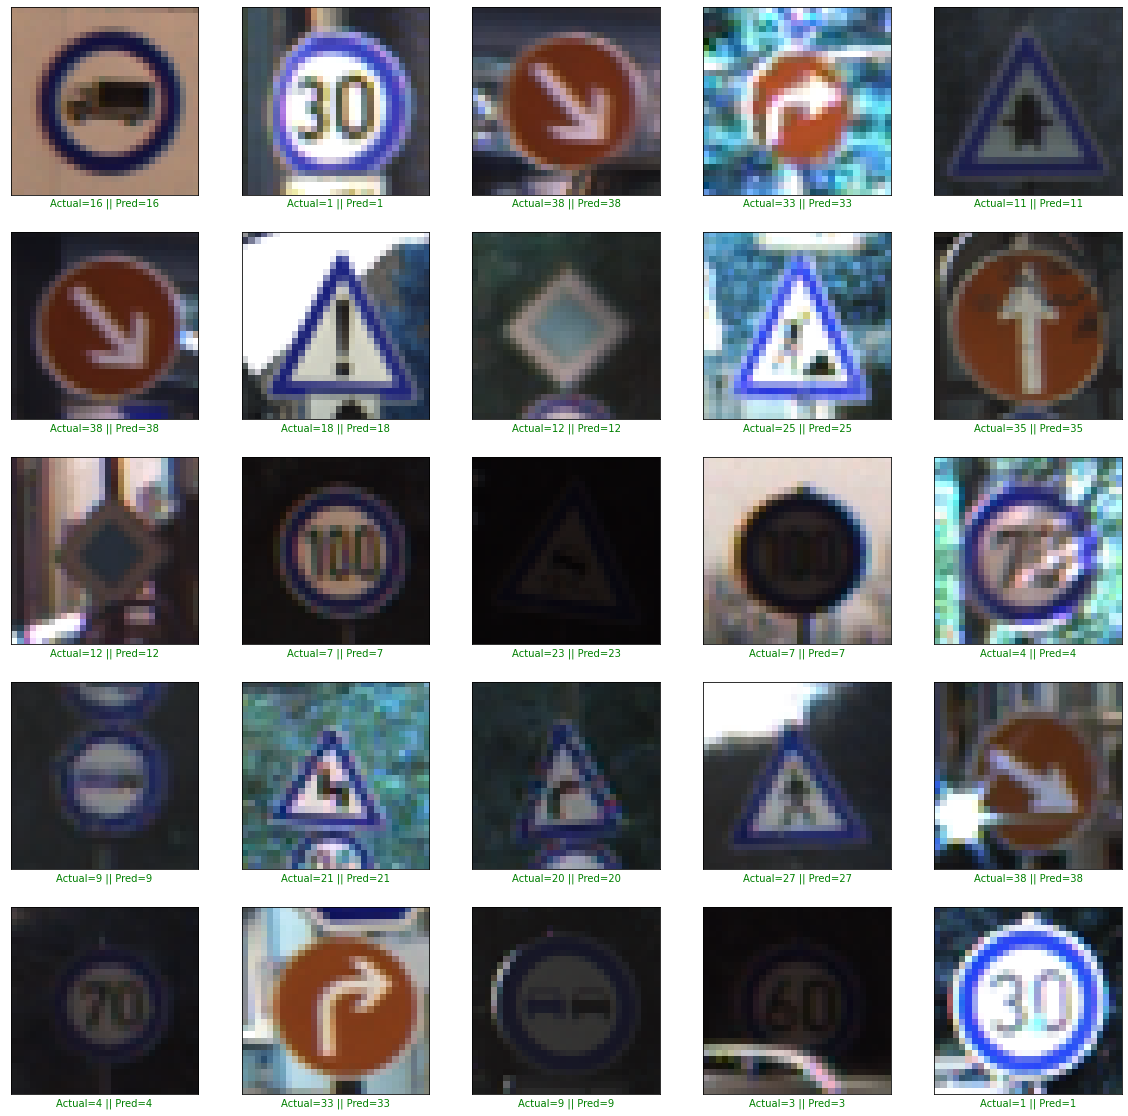

In [19]:
plt.figure(figsize = (20, 20))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()

In [20]:
model.save("final_project.h5")